# **Mastering Time Series Data Splitting: Techniques and Visualizations**

Welcome to this comprehensive exploration of time series data splitting techniques! In this notebook, we will focus on the unique challenges posed by time series data and the importance of preserving its temporal structure when training predictive models. Unlike standard datasets, time series data requires careful consideration during the splitting process to avoid data leakage and ensure valid model evaluation.

We will investigate five popular data splitting methods:
* Holdout
* TimeSeriesSplit
* Sliding Window Split with Fixed Training Window
* Expanding Window Split with Growing Training Set
* Sliding Window with Gap.

Each technique has its own strengths and weaknesses, making it essential to understand their mechanics and appropriate use cases.

Through visualizations and printed indices, we will illustrate how each method operates, providing insights into how they maintain the integrity of time series data. By the end of this notebook, you will have a clearer understanding of how to apply these techniques effectively in your own time series forecasting tasks, helping you build more reliable and accurate models. Let's dive in and enhance our time series analysis skills!

# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
plt.style.use('fivethirtyeight')

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.datasets import co2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load CO2 dataset and preprocess
data = co2.load_pandas().data
data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [ ]:
data.isnull().sum().sum()

59

In [ ]:
data = data['co2'].dropna()

In [ ]:
def plot_cv_indices(cv, data, n_splits, title, generator=False):
    fig, ax = plt.subplots(figsize = (11, 7))
    ax.set_title(title)
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("CV Iteration")

    for i, (train_idx, test_idx) in enumerate(cv if generator else cv.split(data)):
        indices = np.full(len(data), np.nan)
        indices[train_idx] = 1
        indices[test_idx] = 0
        plt.scatter(train_idx, [i+ 0.5] * len(train_idx), color=plt.cm.coolwarm(0.02), marker='_', lw=20)
        plt.scatter(test_idx, [i+ 0.5] * len(test_idx), color=plt.cm.coolwarm(0.8), marker='_', lw=20)

    ytick_labels = list(range(n_splits))
    ax.legend(
        [Patch(color=plt.cm.coolwarm(0.8)), Patch(color=plt.cm.coolwarm(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )

    ax.set(yticks=np.arange(n_splits) + 0.5, yticklabels=ytick_labels)
    ax.set_ylim([n_splits + 0.2, -0.2])
    plt.show()

# **1. Holdout**

The Temporal Holdout Method is a straightforward and widely used approach for splitting time series data into training and testing sets. This method involves selecting a specific proportion of the data for training and using the subsequent data points for testing, ensuring that the model is evaluated on future observations that were not seen during the training phase.

In the Temporal Holdout Method, a fixed percentage of the dataset is allocated to the training set, while the remaining data constitutes the test set. For example, one might choose to allocate 80% of the data for training and 20% for testing. This division respects the chronological order of the data, as time series data are inherently sequential.

* **Advantages**
  * **Simplicity:** The Temporal Holdout Method is easy to implement and understand. It requires minimal computational effort and is straightforward to explain.
  * **Real-World Applicability:** This method mimics real-world scenarios where past data is used to predict future outcomes. It aligns well with how predictive modeling is often deployed in practice.
  * **Data Utilization:** This method allows for a clear separation between training and testing data, enabling straightforward model evaluation on unseen data.
  * **Preservation of Temporal Order:** By training on past data and testing on future data, this method aligns with the natural progression of time series data, reflecting realistic scenarios in predictive modeling.

* **Disadvantages**
  * **Limited Data Usage:** Depending on the percentage split, a significant portion of the data may not be utilized for training, which can be problematic in cases of limited data availability. For example, with a strict 80/20 split, only 80 data points are used for training, which may be insufficient for more complex models.
  * **Lack of Variability:** Since the method involves a single train-test split, it may not capture the variability in model performance across different subsets of data. This can lead to overfitting if the model performs well on the training set but poorly on other unseen data.
  * **No Insight into Temporal Changes:** If the time series exhibits trends or seasonality, a single holdout might not adequately represent these variations, which could lead to misleading performance metrics.

* **When to Use**: The Temporal Holdout Method is particularly useful when you have a large dataset and want a straightforward approach to validate your model. It is also effective for datasets where the temporal order is critical, and you wish to maintain this order during model evaluation.

In [ ]:
data = np.arange(1, 21)

train_percentage = 0.8
train_size = int(len(data) * train_percentage)
test_size = len(data) - train_size

train_index = np.arange(train_size)
test_index = np.arange(train_size, len(data))

print('Temporal Holdout Split:')
print(f'Training indices: {", ".join(map(str, train_index))}')
print(f'Testing indices: {", ".join(map(str, test_index))}\n')

Temporal Holdout Split:
Training indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
Testing indices: 16, 17, 18, 19



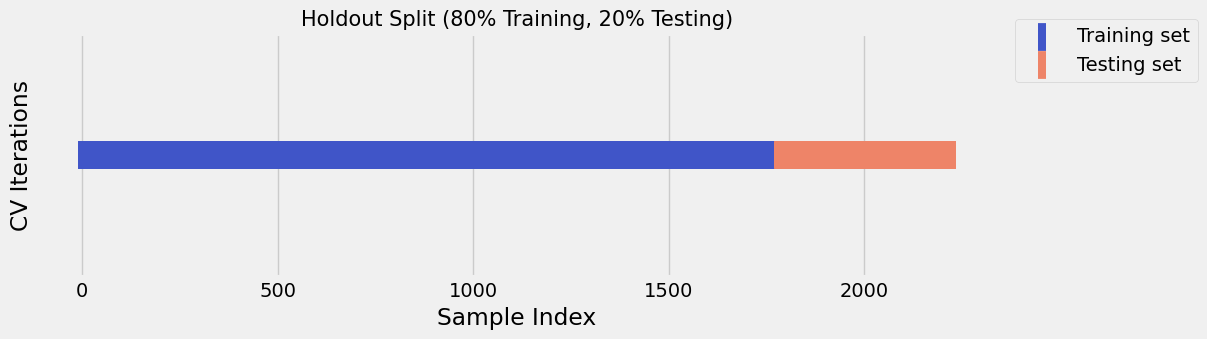

In [ ]:
# Load CO2 dataset and preprocess
data = co2.load_pandas().data['co2'].dropna()

# Define the percentage for training and testing
train_percentage = 0.8  # 80% for training
train_size = int(len(data) * train_percentage)
test_size = len(data) - train_size  # Remaining 20% for testing

# Define training and testing indices for Holdout
train_index = np.arange(train_size)
test_index = np.arange(train_size, len(data))

# Plot the Holdout split
plt.figure(figsize=(11, 3))
plt.scatter(train_index, [0] * len(train_index), color=cmap_cv(0.02), marker='_', lw=20, label='Training set')
plt.scatter(test_index, [0] * len(test_index), color=cmap_cv(0.8), marker='_', lw=20, label='Testing set')

# Formatting the plot
plt.title('Holdout Split (80% Training, 20% Testing)', fontsize=15)
plt.xlabel('Sample Index')
plt.ylabel('CV Iterations')
plt.yticks([])
plt.legend(loc=(1.02, .8))
plt.show()

# **2. TimeSeriesSplit with Expanding Training Set**

In TimeSeriesSplit, each successive split adds more of the dataset into the training set. This means the training data grows larger with each split, allowing the model to learn from a broader context over time. The test set is usually a fixed size or percentage at the end of each split, but the training set starts small and expands to include newer data with each iteration.

* **Advantages:**
  - **Contextual Learning**: The expanding training set provides the model with an increasingly rich context, essential for capturing trends, seasonality, and cyclic patterns.
  - **Better Generalization:** By gradually increasing the training set, the model may better generalize to unseen data.
  * **Improved Forecasting:** By utilizing historical data, the model can better account for temporal dependencies, leading to more accurate long-term forecasts.

* **Disadvantages:**
  * **Computational Cost:** The need to retrain the model with an expanding dataset can significantly increase training time and resource consumption. This can be especially problematic with complex models or large datasets.
  * **Potential Overfitting:** As the model is trained on a larger dataset, it may begin to learn noise rather than signal, particularly if the data contains outliers or anomalies.

* **When to Use:** This method is particularly effective for datasets with historical significance, where earlier data contains valuable insights that can improve model predictions, such as in economic forecasting or climate modeling.

In [ ]:
data = np.arange(1, 21)
n_splits = 5
cv = TimeSeriesSplit(n_splits=n_splits)

for i, (train_index, test_index) in enumerate(cv.split(data)):
    print(f'TimeSeriesSplit {i}:')
    print(f'Training indices: {", ".join(map(str, train_index))}')
    print(f'Testing indices: {", ".join(map(str, test_index))}\n')

TimeSeriesSplit 0:
Training indices: 0, 1, 2, 3, 4
Testing indices: 5, 6, 7

TimeSeriesSplit 1:
Training indices: 0, 1, 2, 3, 4, 5, 6, 7
Testing indices: 8, 9, 10

TimeSeriesSplit 2:
Training indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
Testing indices: 11, 12, 13

TimeSeriesSplit 3:
Training indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
Testing indices: 14, 15, 16

TimeSeriesSplit 4:
Training indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
Testing indices: 17, 18, 19



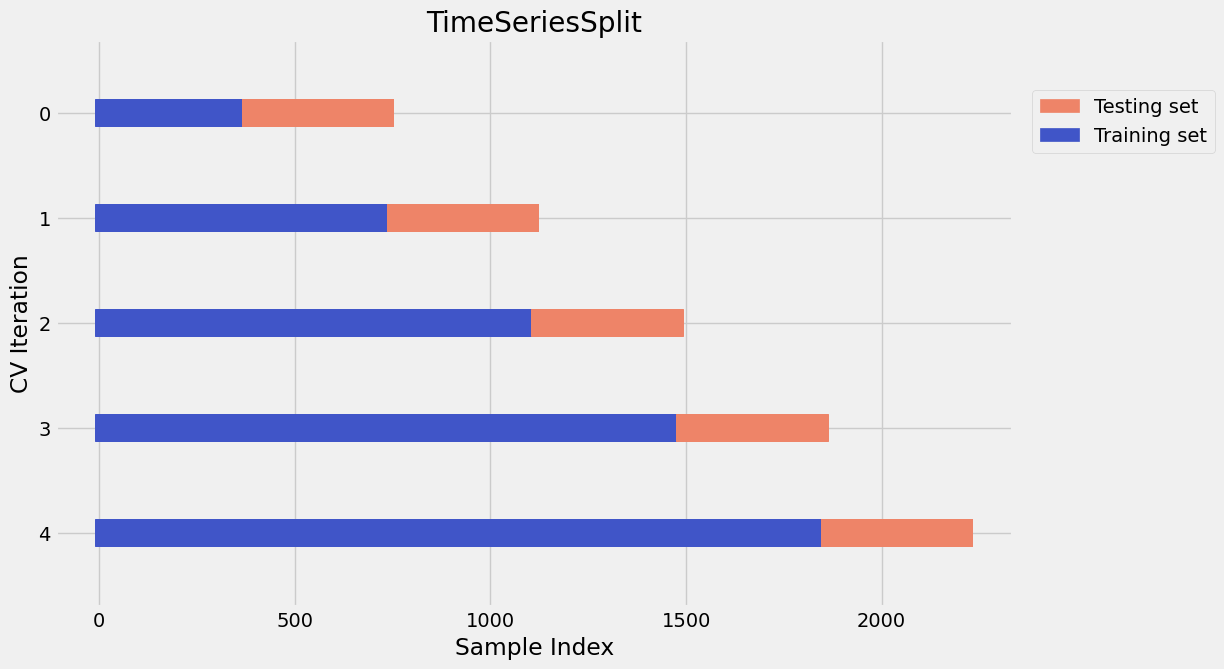

In [ ]:
# 1. TimeSeriesSplit (Rolling Window with Fixed Training Size)
n_splits = 5
time_series_split = TimeSeriesSplit(n_splits=n_splits)
plot_cv_indices(time_series_split, data, n_splits, "TimeSeriesSplit")

# **3. Rolling Window Split with Fixed Training Window**
In Sliding Window Split, the training set is fixed to a specific length (a “window”) and moves forward through the data as each new split is created. Unlike TimeSeriesSplit, the training data size remains constant, so the model is trained on recent data while older observations are dropped.

* **Advantages:**

  * **Relevance of Recent Data:** This technique ensures the model focuses on the most pertinent data, which can be crucial for rapidly changing environments, such as financial markets where trends shift frequently.
  * **Efficient Use of Data:** By regularly updating the training data, this method allows the model to adapt quickly to recent developments, making it suitable for high-velocity datasets.
* **Disadvantages:**

  * **Loss of Historical Information:** Discarding older data can lead to a lack of context, potentially impairing the model's ability to identify long-term trends or cyclical patterns.
  * **Potential Bias:** If recent data is not representative of the overall trend, the model may yield biased predictions, particularly in cases of sudden shifts or anomalies.

* **When to Use:** Ideal for scenarios where the most recent data is likely to be the most informative, such as real-time forecasting for stock prices or demand prediction in fast-moving consumer goods.

In [ ]:
data = np.arange(1, 21)
train_size, test_size = 10, 5

# Calculate the maximum number of splits to use the full dataset
n_splits = (len(data) - train_size) // test_size

for i in range(n_splits):
    train_index = np.arange(i * test_size, i * test_size + train_size)
    test_index = np.arange(i * test_size + train_size, i * test_size + train_size + test_size)

    if test_index[-1] < len(data):
        print(f'SlidingWindowSplit {i}:')
        print(f'Training indices: {", ".join(map(str, train_index))}')
        print(f'Testing indices: {", ".join(map(str, test_index))}\n')

SlidingWindowSplit 0:
Training indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
Testing indices: 10, 11, 12, 13, 14

SlidingWindowSplit 1:
Training indices: 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
Testing indices: 15, 16, 17, 18, 19



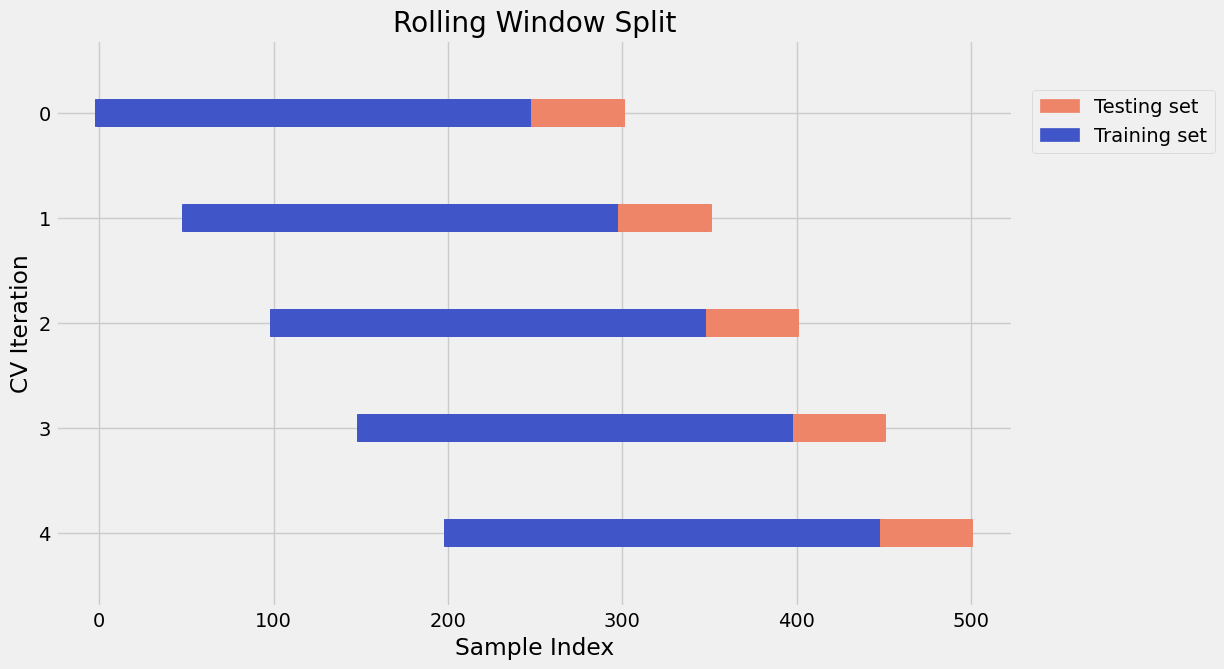

In [ ]:
# 2. Sliding/Rolling Window Split with Fixed Training Size
def rolling_window_split(data, n_splits, train_size, test_size):
    for i in range(n_splits):
        train_idx = np.arange(i * test_size, i * test_size + train_size)
        test_idx = np.arange(i * test_size + train_size, i * test_size + train_size + test_size)
        yield train_idx, test_idx

train_size, test_size, n_splits = 250, 50, 5
rolling_window_cv = rolling_window_split(data, n_splits, train_size, test_size)
plot_cv_indices(rolling_window_cv, data, n_splits, "Rolling Window Split", generator=True)

# **4. Expanding Window Split with Growing Training Set**
Expanding Window Split is similar to TimeSeriesSplit but differs in that the training set expands to include all data up to each new split without a predefined test split size. As a result, each test set can be shorter or longer, depending on the approach.

* **Advantages:**
  - **Comprehensive Context:** The model can take advantage of all prior information, leading to potentially better predictive performance as it learns from the entirety of the dataset.
  - **Flexibility in Test Set Size:** This method allows researchers to explore different configurations for the test set, offering versatility in model evaluation.

* **Disadvantages:**
  - **Imbalance in Training/Test Sizes:** As the training dataset grows, the test set may become too small, leading to unreliable evaluation metrics and diminishing the ability to assess generalization accurately.
  - **Increased Complexity:** The growing dataset can complicate the training process, requiring more careful tuning and validation techniques to ensure the model remains effective.

* **When to Use:** Suitable for datasets where historical context is crucial, such as energy consumption forecasting or any application where understanding past behavior significantly influences future predictions.

In [ ]:
data = np.arange(1, 21)
initial_train_size, test_size = 10, 5

# Calculate the maximum number of splits to use the full dataset
n_splits = (len(data) - initial_train_size) // test_size

for i in range(n_splits + 1):
    train_index = np.arange(0, initial_train_size + i * test_size)
    test_index = np.arange(initial_train_size + i * test_size, initial_train_size + (i + 1) * test_size)

    if test_index[-1] < len(data):
        print(f'ExpandingWindowSplit {i}:')
        print(f'Training indices: {", ".join(map(str, train_index))}')
        print(f'Testing indices: {", ".join(map(str, test_index))}\n')

ExpandingWindowSplit 0:
Training indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
Testing indices: 10, 11, 12, 13, 14

ExpandingWindowSplit 1:
Training indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
Testing indices: 15, 16, 17, 18, 19



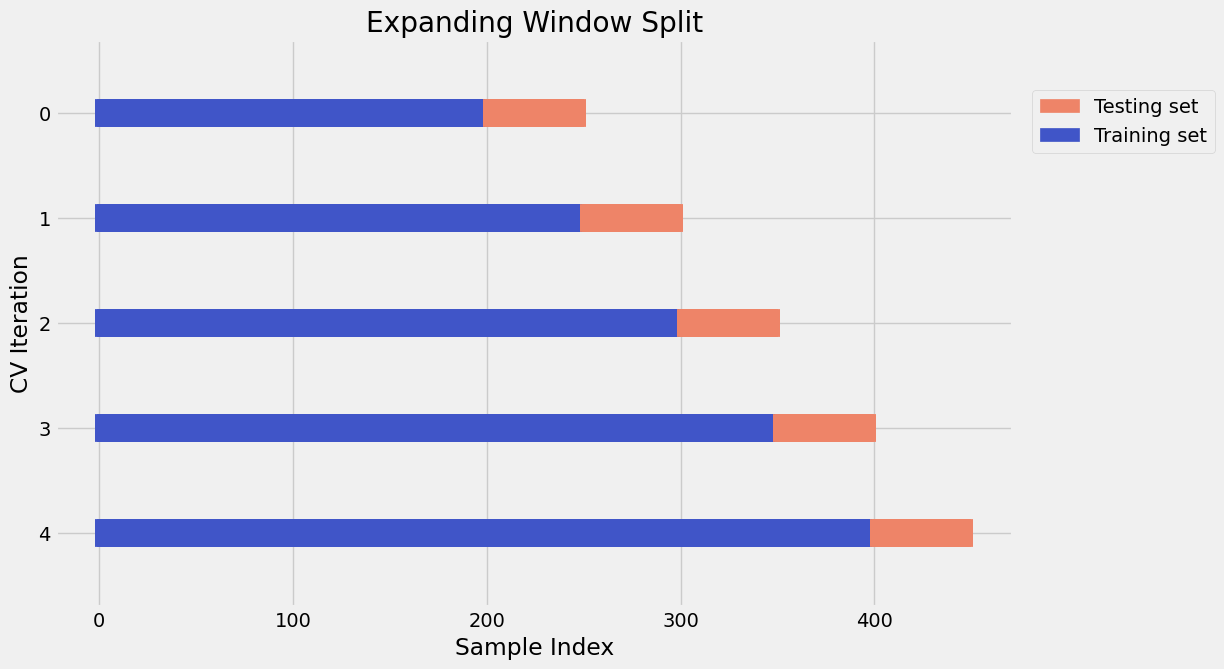

In [ ]:
# 3. Expanding Window Split
def expanding_window_split(data, n_splits, initial_train_size, test_size):
    for i in range(n_splits):
        train_idx = np.arange(0, initial_train_size + i * test_size)
        test_idx = np.arange(initial_train_size + i * test_size, initial_train_size + (i + 1) * test_size)
        yield train_idx, test_idx

initial_train_size, test_size, n_splits = 200, 50, 5
expanding_window_cv = expanding_window_split(data, n_splits, initial_train_size, test_size)
plot_cv_indices(expanding_window_cv, data, n_splits, "Expanding Window Split", generator=True)

# **5. Sliding Window with Gap**
In Sliding Window with Gap, there’s a fixed training window that moves forward in steps, similar to the sliding window approach, but with a “gap” between the end of the training data and the start of the test data. This gap ensures that the model is not overly influenced by adjacent data points, which can be beneficial if those points are likely to be correlated.

* **Advantages:**
  * **Prevention of Information Leakage:** By ensuring a gap, the model is less likely to be influenced by future data, resulting in a more honest evaluation of its predictive capabilities.
  * **Adaptability:** The method can be tailored based on the specific characteristics of the time series, such as the autocorrelation present in the data, allowing for better modeling of patterns.

* **Disadvantages:**
  * **Reduced Test Set Size:** The gap may lead to smaller test sets, which can hinder the robustness of the evaluation if not carefully managed.
  * **Complexity in Setup:** Determining the optimal size for the gap requires careful consideration and experimentation, which can complicate the implementation process.

* **When to Use:** This method is particularly useful for high-frequency datasets where the relationship between observations can change rapidly, such as in sensor data analytics or algorithmic trading, where timely predictions are essential.

In [ ]:
data = np.arange(1, 41)
train_size, test_size, gap = 10, 5, 5

# Calculate the maximum number of splits to use the full dataset
n_splits = (len(data) - train_size - test_size - gap) // (test_size + gap) + 1

for i in range(n_splits):
    train_index = np.arange(i * (test_size + gap), i * (test_size + gap) + train_size)
    test_index = np.arange(i * (test_size + gap) + train_size + gap,
                           i * (test_size + gap) + train_size + gap + test_size)

    if test_index[-1] < len(data):
        print(f'SlidingWindowWithGapSplit {i}:')
        print(f'Training indices: {", ".join(map(str, train_index))}')
        print(f'Testing indices: {", ".join(map(str, test_index))}\n')

SlidingWindowWithGapSplit 0:
Training indices: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
Testing indices: 15, 16, 17, 18, 19

SlidingWindowWithGapSplit 1:
Training indices: 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
Testing indices: 25, 26, 27, 28, 29

SlidingWindowWithGapSplit 2:
Training indices: 20, 21, 22, 23, 24, 25, 26, 27, 28, 29
Testing indices: 35, 36, 37, 38, 39



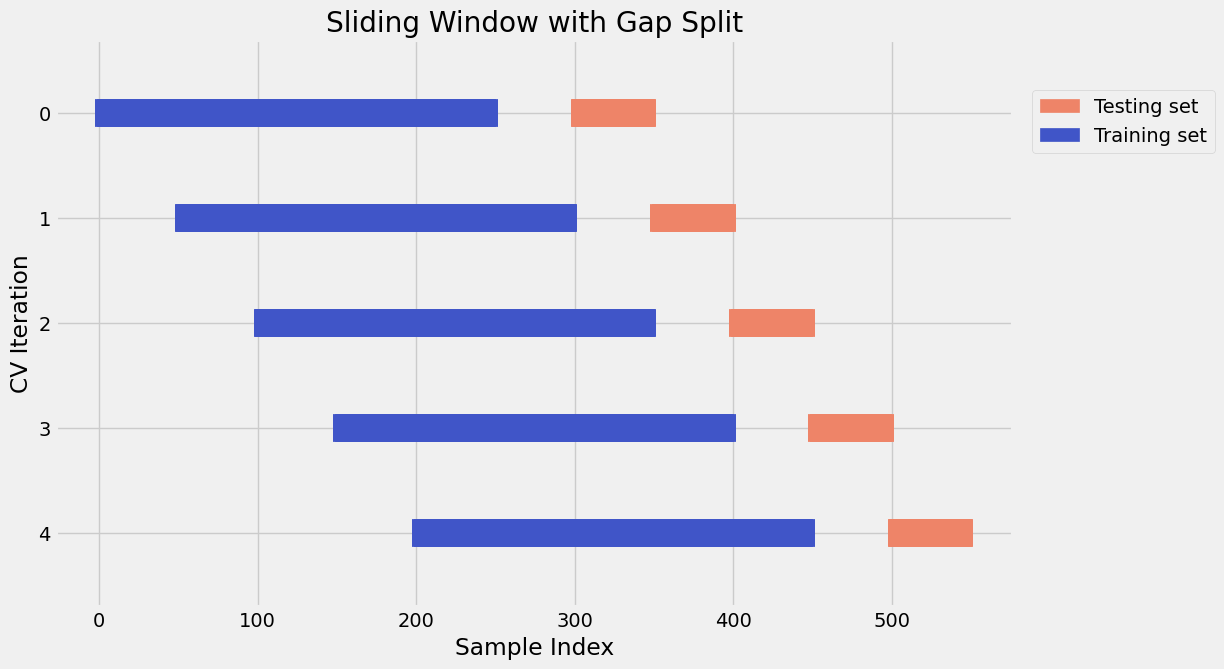

In [ ]:
# 4. Sliding Window with Gap Split
def sliding_window_with_gap_split(data, n_splits, train_size, test_size, gap):
    for i in range(n_splits):
        train_idx = np.arange(i * test_size, i * test_size + train_size)
        test_idx = np.arange(i * test_size + train_size + gap, i * test_size + train_size + gap + test_size)
        yield train_idx, test_idx

train_size, test_size, gap, n_splits = 250, 50, 50, 5
sliding_window_gap_cv = sliding_window_with_gap_split(data, n_splits, train_size, test_size, gap)
plot_cv_indices(sliding_window_gap_cv, data, n_splits, "Sliding Window with Gap Split", generator=True)

# **Conclusion**

This table provides a comparative overview of time series data splitting techniques, summarizing each method's strengths, limitations, and ideal use cases to help practitioners select the most effective approach for their specific forecasting or analysis needs.

| Technique              | Training Set Growth| Testing Set Growth | Gap Handling | Best Suited For | Advantages | Disadvantages |
| :---------------- | :------: | ----: | :------: | :------: |:------: |:------: |
| Temporal Holdout        |   Fixed   | Fixed | No | Initial evaluations, <br>quick checks       |   Simple to implement; <br>gives a baseline model performance   | Limited; doesn’t <br>represent changing data over time |
| TimeSeriesSplit       |   Growing   | Fixed Length <br>(Sliding) | No | Consistent period <br>testing over time      |   Provides a balanced view across time;<br> easy to set up   | Assumes stationarity;<br> may under-represent recency |
| Sliding Window Split       |   Fixed Length <br>(Sliding)   | Fixed Length <br>(Sliding) | Optional | Short-term <br>forecasting with recency bias |   Focuses on most recent data;<br> suitable for shifting trends   | Potential data leakage;<br> can ignore older patterns |
| Expanding Window        |   Growing   | Fixed Length <br>(Sliding) | No | Long-term trend analysis      |   Captures cumulative information;<br> realistic for long-term models   | Can get computationally <br>expensive over many splits |
| Sliding w/ Gap Split        |   Fixed Length <br>(Sliding)   | Fixed Length <br>(Sliding) | Yes | Real-time <br>prediction without lookahead       |   Prevents data leakage with gap; <br>emphasizes recency  | Requires careful parameter tuning;<br> can miss past patterns |


In summary, the choice of time series splitting technique should be informed by the specific context of the data and the goals of the analysis. Understanding the strengths and weaknesses of each method allows practitioners to select the most appropriate approach for their particular application, whether it be for enhancing predictive accuracy, ensuring robust evaluations, or maintaining the relevance of the model to current trends. Ultimately, a thoughtful approach to data splitting is crucial in building reliable predictive models in time series analysis, as it directly influences model performance and the quality of insights derived from the data.